Economic indicators are statistics to measure growth and contraction of econmics. Trading based on such indicators, what is called technical trading, is one of the main trends in recent stock trading. Especially SP500(Standard and Poor's 500 Index) is frequently used as a bench mark to evaluate portfolio -- a grouping of financial assets like stocks. Roughly speaking, constructing a portfolio with better return and lower risk than SP500 is one of the main goals for strock trading. Therefore, clarfiying the relation between SP500 and stock prices are important to construct a good portfolio.

In this article, we work on duplication of SP500 with stock price data. At first part, we use various lienar models like linear regression, factor anlaysis, etc. In the latter part, we also consider an extension with neural network. We show that the neural network as an extension of linear regression works better than a simple neural network.

# Analysis Environment

We basically work with 'sklearn' and also use 'keras' and 'tensorflow' for implementation of neural networks. For fetching data, we will use a local library [utils.py](https://github.com/jjakimoto/Indicator_Analysis/blob/master/utils.py). 

In [1]:
from __future__ import print_function

import pickle
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
import sys
import copy
import time
import tensorflow as tf
import keras
import sklearn
from six.moves import xrange
import matplotlib.pyplot as plt
%matplotlib inline

# local library
import utils

Using TensorFlow backend.


We fetch stock price and S&P500 data from open source, yahoo finance. We also refer to [the Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) to get informaion about which stocks are used for S&P500. For precise implementation, you can check [here](https://github.com/jjakimoto/Indicator_Analysis/blob/master/utils.py).

In [226]:
%%time

print ("Started!!")
symbols = utils.get_sap_symbols('sap500')
np.random.shuffle(symbols)
start_date="2012-10-01"
end_date="2016-04-01"
# use Open data
input_data = utils.get_data_list_key(symbols, start_date, end_date)
target_data = utils.get_data('^GSPC', start_date, end_date)['Open']

Started!!
we cound not fetch data from the following companies
['NEE', 'NWS', 'CSRA', 'HPE', 'CFG', 'WRK', 'PYPL', 'UA', 'COTY', 'QRVO', 'SYF', 'EVHC', 'ZTS', 'NWSA', 'ALLE', 'ABBV', 'MNK', 'KHC', 'WLTW', 'FTV', 'NAVI']
CPU times: user 7.89 s, sys: 988 ms, total: 8.88 s
Wall time: 3min 1s


Due to the lack of some data from "2012-10-01" to "2016-04-01", 484 companies stock data can be used at maximum.

# Breaking Down S&P500

S&P500 is calculated by linear combination of U.S. 500 stocks selected by economists. The weight parameters for each stock is determined by [market capitals](http://www.investopedia.com/ask/answers/05/sp500calculation.asp). 
Thus, we can write down the relation of S&P500 and stock prices as 
$$y = \bf{w}\cdot \bf{x} ,$$
where $y$ and $\bf{x}$ are S&P500 and stock prices; $\bf{w}$ and $\bf{x}$ are 500 dimensional vectors. This simple linear relation enables even a vanilla linear regression to duplicate S&P500 with high accuracy under a certain condition.

Let's work on linear regression! We use three years data for training and an half an year data for test.

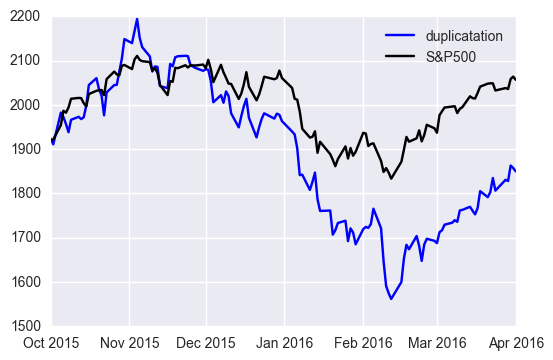

In [7]:
plt.plot(test_target.index, prediction, label='duplicatation', color='b')
plt.plot(test_target, label='S&P500', color='k')
_ = plt.legend()

This result looks succeding in the first part but failing in the latter part. To evalute this peformance quantitatively, we shall introduce an accuracy.

### Accuracy

Risk and return in a portfolio are usually evaluated as the percentage. Thus, when S&P500 is used as a benchmark of portoflios's perforamance, the percentage evaluation is more appropriate than the value itself. Then, we use the following accuracy:
$$ \frac{1}{N} \sum_1^N \frac{|\tilde{y_i} - y_i|}{y_i}, $$
where $\tilde{y_i}$ and $y_i$ are duplicatation and truth value of S&P500.

Since data contains a lot of noise, we need smoothing to see how the error changes along with time. Then, we evaluate error for every two weeks average.

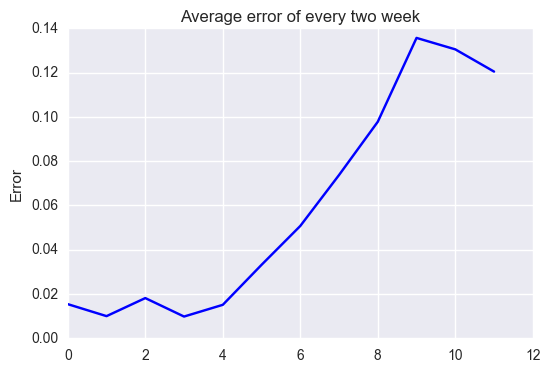

In [40]:
fig, ax = plt.subplots()
ax.set_ylabel('Error')
ax.set_title('Average error of every two week')
_ = ax.plot(errors_linear,  color='b')

x-axis number indicate x-th two weeks average: i.e., x-th two weeks average is the average from 2*x th to 2*(x + 1) th week average. While we have less than 2% error in the first two weeks, we have almost 12% ~ 14% error in the latter part. The error grows along with time. This implies that the weight parameters vary as the economic condition changes along with time. From now on, taking the linear regression result above as a bench mark, we work on various algorithms and compare their performance.

# Factor Analysis: Probailistic PCA(PPCA) and PCA

Stock prices are konwn to behave while correlating to each other. If this correlation can be described as linear combinations, the dimension of independent factors that determines stock prices is equal to or less than the number of stocks. Thus, input information may be able to reduce to lower dimension. With this view point, the duplication of fiancial indicators like S&P 500 traditionally has been doen with factor analysis. We will now work on PCA and factor analysis(PPCA). 

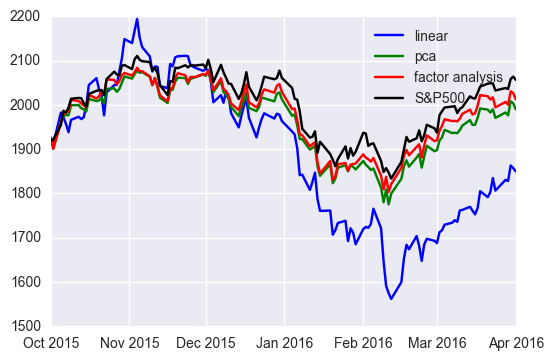

In [16]:
plt.plot(test_target.index, prediction, label="linear", color='b')
plt.plot(test_target.index, prediction_pca, label='pca', color='g')
plt.plot(test_target.index, prediction_fa, label='factor analysis', color='r')
plt.plot(test_target, label="S&P500", color='k')
_ = plt.legend()

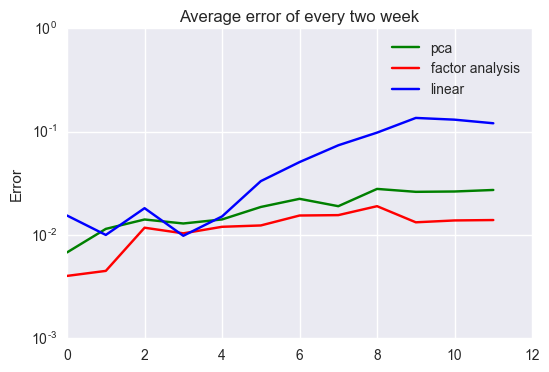

In [17]:
fig, ax = plt.subplots()

ax.set_ylabel('Error')
ax.set_title('Average error of every two week')
ax.set_yscale("log")

ax.plot(errors_pca, label='pca', color='g')
ax.plot(errors_fa, label='factor analysis', color='r')
ax.plot(errors_linear, label='linear', color='b')
_ = ax.legend()

PPCA has the best performance almost all over observations. Note that both PCA and PPCA have better peformances  than the linear regression especially at the latter observations. This comes from the fact that simple model is robust to unobserved data. Since the latter part data is changes a lot from train data, the vanilla linear regression fails in generalization and results in poor performance.

# Duplication with Subsets of Stocks

In practical situation, you may use fewer stocks to constitute your portfoilo. Since S&P is often used as bentch mark for performance of portforlios, we have to keep larger return and lower risk compared to S&P500. Therefore, to hedge risk and maximize return, it is important to figure out the relation between S&P500 and subset of stocks. 

## Automatic Relevance Determination

The contribution of each stock toward S&P500 will be detemined by the scale of company -- market cap. Thus, stocks of only some influential companies may have dominant effect on the behavior of S&P500. In that case, focusing on such terms makes the model robust and have better generalization error. ARD(Automatic Relevance Determination) is one of the bayesian methods to choose dominant factors by introducing diagonal covariance noraml distributed prior for weight parameters. Roughly speaking, this algorithm will choose the most important factors automatically.

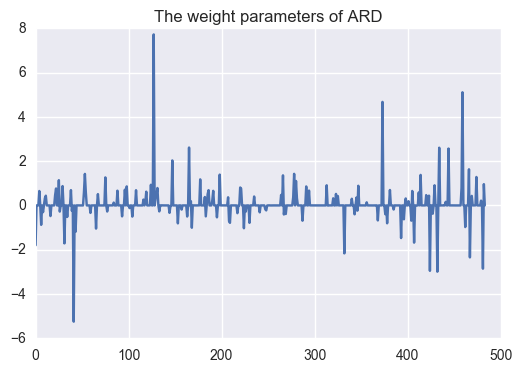

In [237]:
fig, ax = plt.subplots()
_ = ax.plot(ard.coef_)

_ = ax.set_title('The weight parameters of ARD')

Only 218 companis out of 484 companies are chosen to use; i.e. almost half of stocks are used. Let's see the performance.

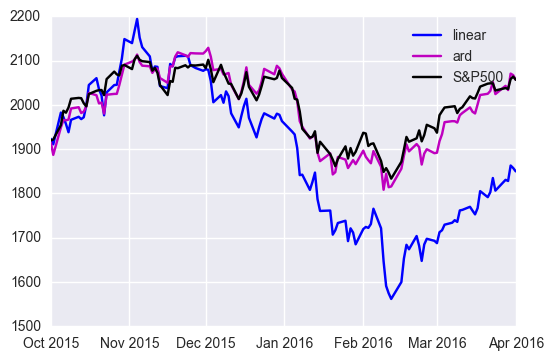

In [19]:
prediction_ard = ard.predict(test_input.values)
plt.plot(test_target.index, prediction, label="linear", color='b')
plt.plot(test_target.index, prediction_ard, label='ard', color='m')
plt.plot(test_target, label='S&P500', color='k')
_ = plt.legend()

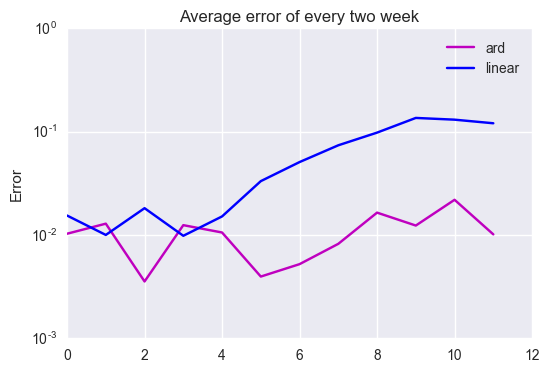

In [21]:
fig, ax = plt.subplots()

ax.set_ylabel('Error')
ax.set_title('Average error of every two week')
ax.set_yscale("log")

ax.plot(errors_ard, label='ard', color='m')
ax.plot(errors_linear, label='linear', color='b')
_ = ax.legend()

In the same way as factor analysis, the dimension reduction keep error rate with 1.0e-2 order even in the latter part.

## Linear Regression with Subset of Large Volume Stocks

We will now consider using only 10% of selected stocks, i.e., 50 stocks.

We shall choose 50 stocks based on volume: quntity refers to the number of traded contracts. Roughly speaking, the more volume a company has, the stronger impact it has on the stock market. Hence, it is natural to choose the 50 biggest volume companies to duplicate S&P500.  Technically, we use the average volume over the observation period. 

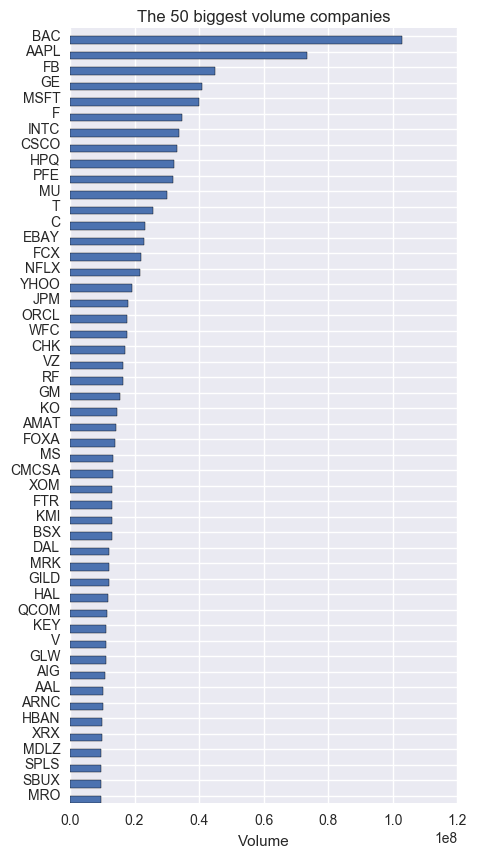

In [232]:
idx = np.arange(len(chosen_symbol))  
height = 0.5

fig, ax = plt.subplots(figsize=[5, 10])
_ = ax.barh(idx, chosen_volume[::-1], height)

# add some text for labels, title and axes ticks
ax.set_xlabel('Volume')
ax.set_title('The 50 biggest volume companies')
ax.set_yticks(idx + height)
_ = ax.set_yticklabels(chosen_symbol[::-1])

Let's see the relation between stocks choen by ARD and Volume.

In [235]:
print(common)

['SPLS', 'HBAN', 'EBAY', 'HAL', 'PFE']


Subset linear regression and ARD share only 5 out of 50, 10%, stocks, which implies that the contribution of each stock for S&P500 cannot be described by simple volume. Let's see the performance.

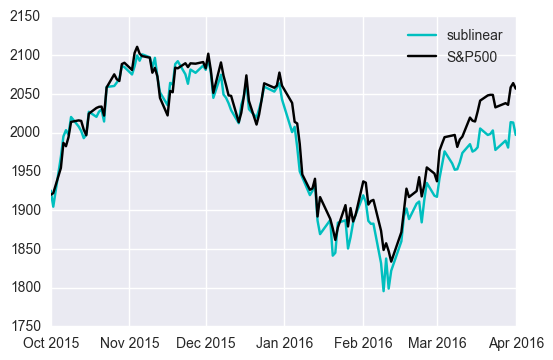

In [92]:
regr = LinearRegression()
regr.fit(train_input.values, train_target.values)

prediction_sub = regr.predict(test_input.values)

plt.plot(test_target.index, prediction_sub, label='sublinear', color='c')
plt.plot(test_target, label='S&P500', color='k')
plt.legend()

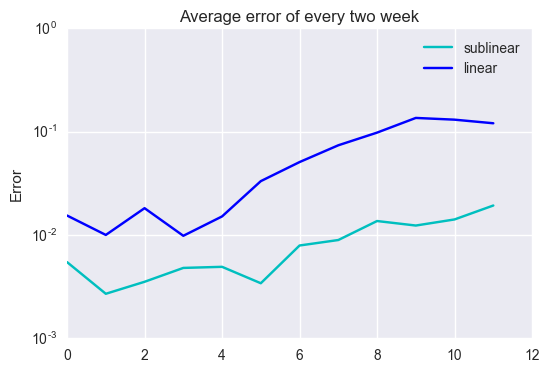

In [93]:
errors_sub = []
for i in xrange(len(prediction) // 10):
    errors_sub.append(error(prediction_sub[i*10:(i+1)*10], test_target.values[i*10:(i+1)*10])) 
    
fig, ax = plt.subplots()
ax.set_ylabel('Error')
ax.set_title('Average error of every two week')
ax.set_yscale("log")
ax.plot(errors_sub, label='sublinear', color='c')
ax.plot(errors_linear, label='linear', color='b')
_ = ax.legend()

Focusing on only the large volume stocks improves the perforamcne over all of the observations. This implies that the largest volume stocks are the dominant factors.

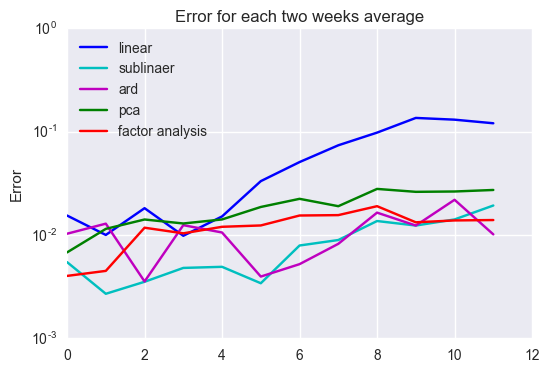

In [94]:
fig, ax = plt.subplots()

# add some text for labels, title and axes ticks
ax.set_ylabel('Error')
ax.set_title('Error for each two weeks average')
ax.set_yscale("log")

ax.plot(errors_linear, label='linear', color='b')
ax.plot(errors_sub, label='sublinaer', color='c')
ax.plot(errors_ard, label='ard', color='m')
ax.plot(errors_pca, label='pca', color='g')
ax.plot(errors_fa, label='factor analysis', color='r')
_ = ax.legend(loc='upper left')

As you see in the above figure, dimension reduction has an effect of keeping good performance in the latter part. One of the reasons comes from the fact that variance beomes smaller when having fewer variables for linear regression., e.g. the benchmark linear regression has ten times a much variabales as the linear regression with the 50 largest volume companies, which gives ten times varaince if all of the variables are i.i.d. Thus, the change of stock prices along with time gives more error to the benchmark than to other model with fewer dimensions. 

# Neural Network

Stocks may have nonlinear correlation, which require more complex model than linear model discussed above. In this section, we apply neural network to the duplication of S&P500. Neural network has been recently attracting a lot of attentions due to the great success in image recognition. According to [Universal Approximation Theorem](http://deeplearning.cs.cmu.edu/pdfs/Kornick_et_al.pdf), we can approximate almost any functions. More precisely, let $f$ be a borel function mapping from $\mathbb{R}^n$to $\mathbb{R}^r$. Let $\bf{X}$ a space of one layer simple feed forward neural network with a certain class activation function like sigmoid, tanh, Relu, etc. For any $\epsilon > 0$ and compact subset $K \subset \mathbb{R}^n$, there exists $\tilde{f} \in \bf{X}$ such that 
$$ \underset{x \in K}{sup}\| f(x) - \tilde{f}(x)\| < \epsilon.$$
In the original paper, more general statement has been shown. Most of funcions you see are included in borel function, unless you work on pure mathematics. Hence, we can say that we can choose a neural network for almost any funciton with any accuracy. 

Note that this statement, however, is just qualitative. The approximation is not constructive and does not give any ideas as to how to determine the number of hidden. 

Now, we implement a multi layer perceptron taking output as duplication of S&P500. Generally speaking, the batch normalization has an effect to make learning faster and avoid over fitting by reducing covariate shift. Application of batch normalization to output layer, however, makes a model unstable because of scales difference between target value and batch normalized output. Therefore, we will use batch normalization for all layers but the last layer. 

CPU times: user 94.6 ms, sys: 21.6 ms, total: 116 ms
Wall time: 117 ms


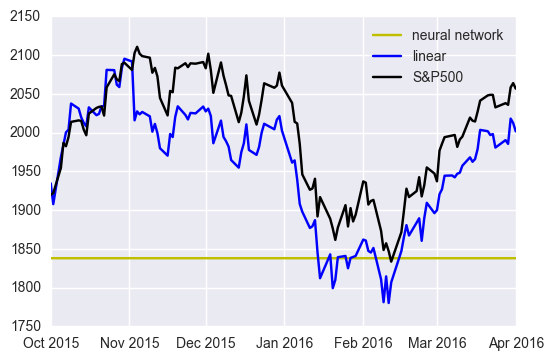

In [260]:
%%time
prediction_nn = mlp.predict(test_input)

plt.plot(prediction_nn, label='neural network', color='y')
plt.plot(test_target.index, prediction, label='linear', color='b')
plt.plot(test_target, label='S&P500', color='k')
_ = plt.legend()

The network just adjust output to the scale of S&P500 by increasing bias and produce almost the same value irrelevant to input values. This is one of the examples to indicate that  Universal Approximation Theorem does not grantee that we can easily find the optimal solutions. Before implementing network, we have to establish a model that reflects the charactersitc of data.

Since S&P500 consists of linear combination of stocks, duplication has to satisfy the linear sensitivity with respect to stock prices, which is not satisfied by the simple nerual network. Instead, we use the network to learn weight like linear regression: i.e.
$$\bf{f(\bf{x})}\cdot \bf{x},$$
where $\bf{f}(\cdot)$ is the output of the neural network.

CPU times: user 77.8 ms, sys: 2.52 ms, total: 80.3 ms
Wall time: 73.3 ms


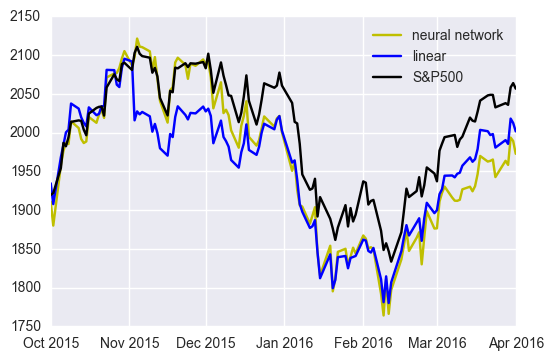

In [223]:
%%time
prediction_nn = mlp.predict(test_input)

plt.plot(prediction_nn, label='neural network', color='y')
plt.plot(test_target.index, prediction, label='linear', color='b')
plt.plot(test_target, label='S&P500', color='k')
_ = plt.legend()

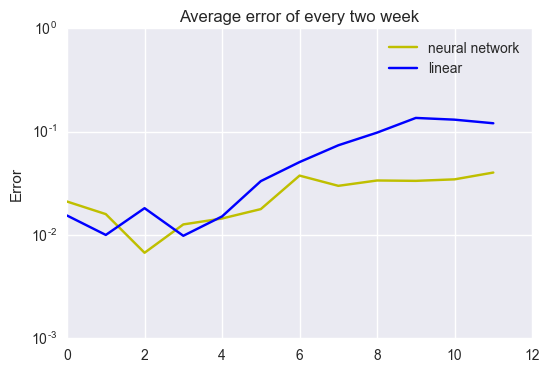

In [224]:
errors_nn = []
for i in xrange(len(prediction) // 10):
    errors_nn.append(error(prediction_nn.values[i*10:(i+1)*10], test_target.values[i*10:(i+1)*10])) 
    
fig, ax = plt.subplots()
ax.set_ylabel('Error')
ax.set_title('Average error of every two week')
ax.set_yscale("log")
ax.plot(errors_nn, label='neural network', color='y')
ax.plot(errors_linear, label='linear', color='b')
_ = ax.legend()

The change of architecture improves the performance.

# Conclusion

Reducing dimensions has an effect of reduction of varaicne for the duplication of S&P500, which leads to the better performance in the latter part of observations. Especially, we have better performance when choosing only dominant factors: large volume companies' stocks. 

Nonlinearlity and universal approximation theorem makes neural network attractive. Neural network, however,  is difficult to determine the optimal hyper parameters and optimize parameters. As you seen in the example, a simple archtecture taking stock price as input and output as duplication does not fit data at all. Introducing linear regression structure does the trick. Thus, when applying neural network, we have to consider which parts network should lbe applied to; otherwise, we fail in even fitting training data. 

Various research has been done for neural network. As a future work, we can apply state of art algorithms to prediction of S&P500 with the historical data. 